In [ ]:
from pandas import read_csv, unique

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [ ]:
def read_data(filepath):
    df = read_csv(filepath, header=None, names=['user-id',
                                               'activity',
                                               'timestamp',
                                               'X',
                                               'Y',
                                               'Z'])
    ## removing ';' from last column and converting it to float
    df['Z'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    df['Z'] = df['Z'].apply(convert_to_float)
    return df

def convert_to_float(x):
    try:
        return np.float64(x)
    except:
        return np.nan

df = read_data('WISDM_ar_v1.1_raw.txt')
df


,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
109061,13,Jogging,1.512342e+12,-2.830000,16.780000,3.677494
109062,13,Jogging,1.512393e+12,-8.160000,1.730000,-9.806650
109063,13,Jogging,1.512442e+12,-8.770000,19.110000,-6.129157
109064,13,Jogging,1.512493e+12,5.370000,19.380000,13.593107


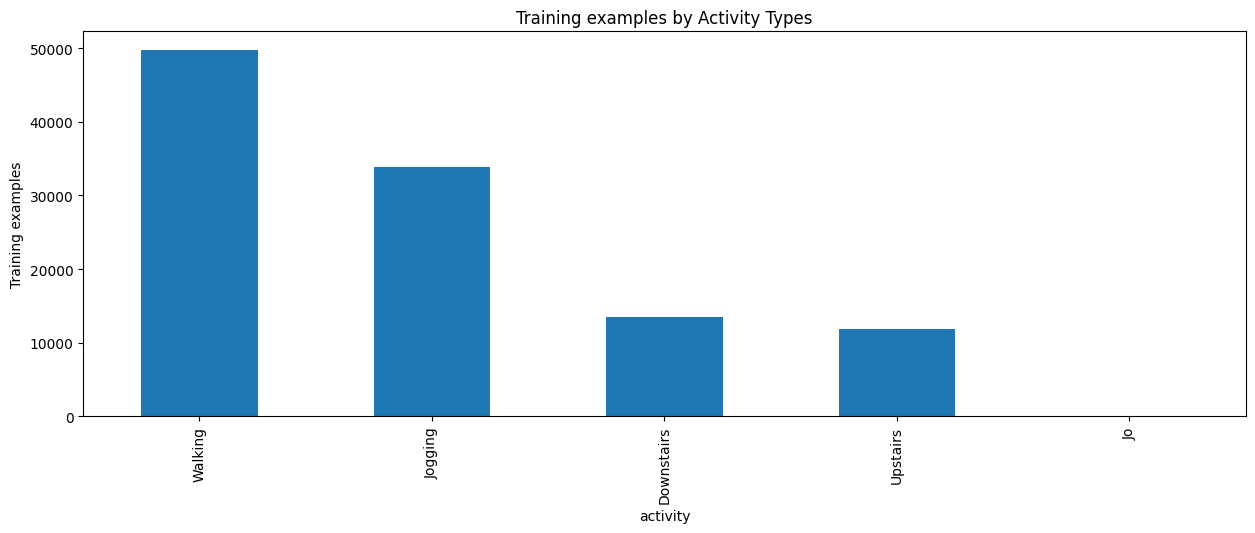

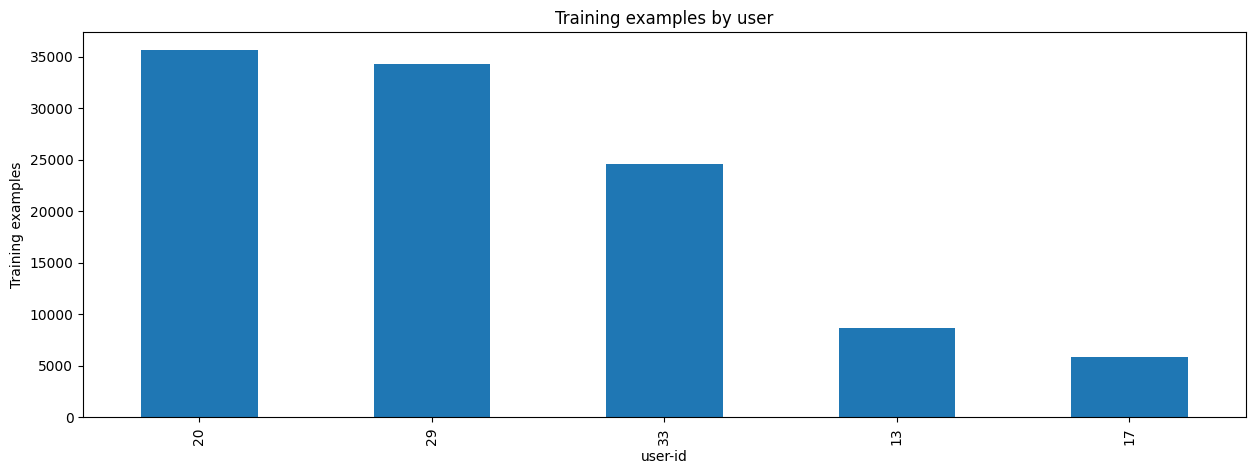

In [ ]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar',
                                 title='Training examples by user')
plt.show()

In [ ]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    # Handle potential NaN/Inf values in y
    valid_y = y[np.isfinite(y)]  # Filter out NaN and Inf values
    if valid_y.size > 0:  # Check if there are any valid values left
        y_min = np.min(valid_y)
        y_max = np.max(valid_y)
        y_std = np.std(valid_y)
        ax.set_ylim([y_min - y_std, y_max + y_std])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [ ]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [ ]:
def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    # Handle potential NaN/Inf values in y
    valid_y = y[np.isfinite(y)]  # Filter out NaN and Inf values
    if valid_y.size > 0:  # Check if there are any valid values left
        y_min = np.min(valid_y)
        y_max = np.max(valid_y)
        y_std = np.std(valid_y)
        ax.set_ylim([y_min - y_std, y_max + y_std])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

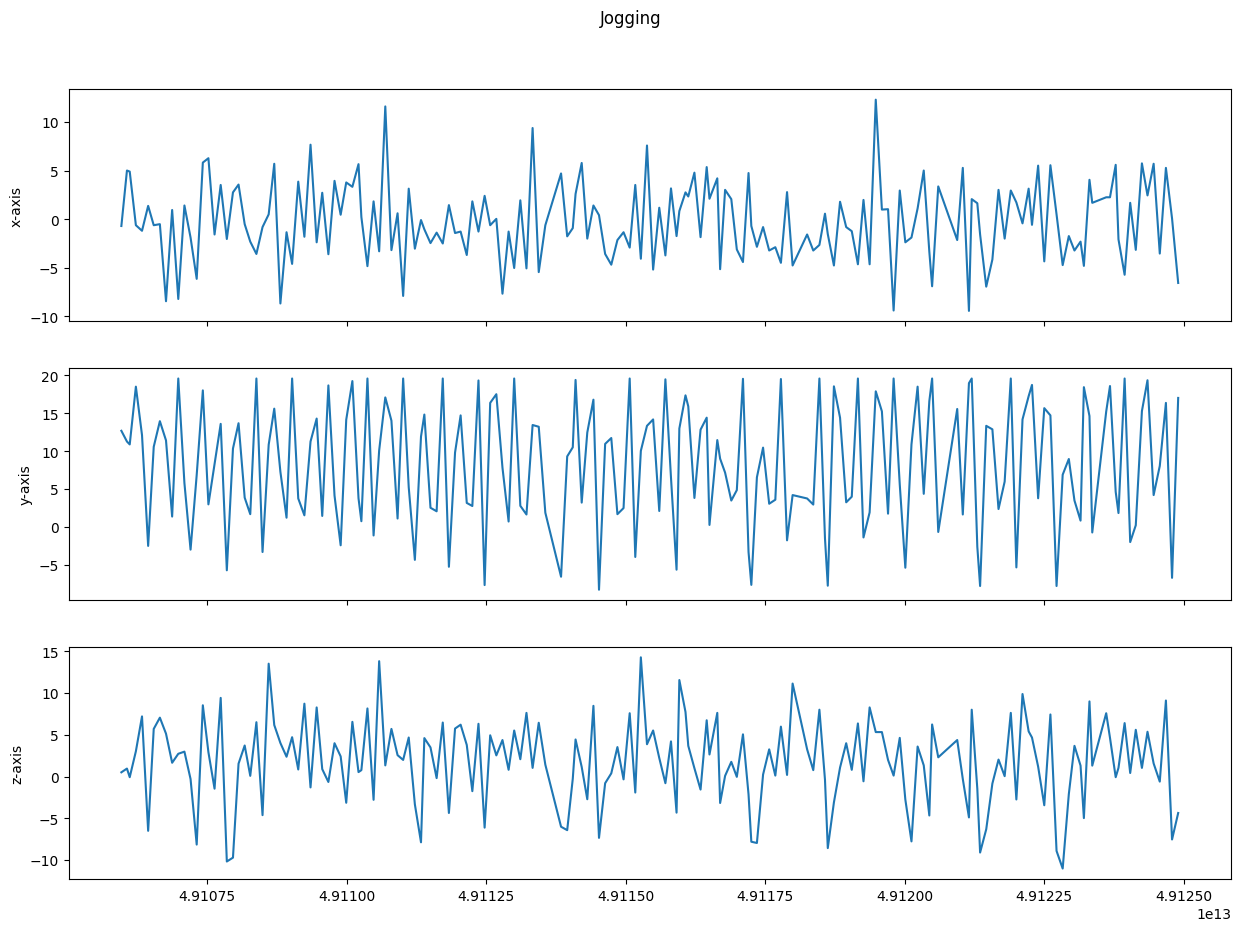

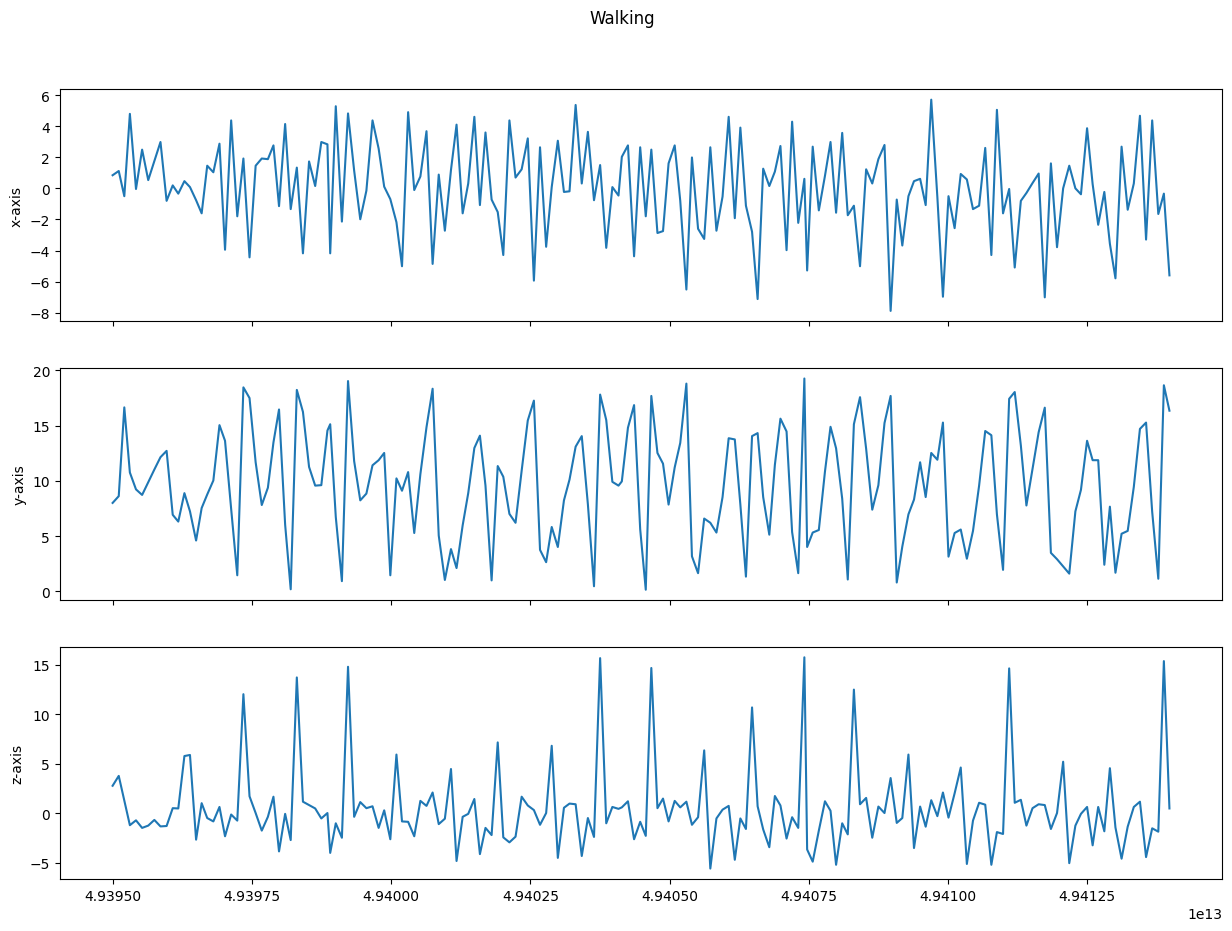

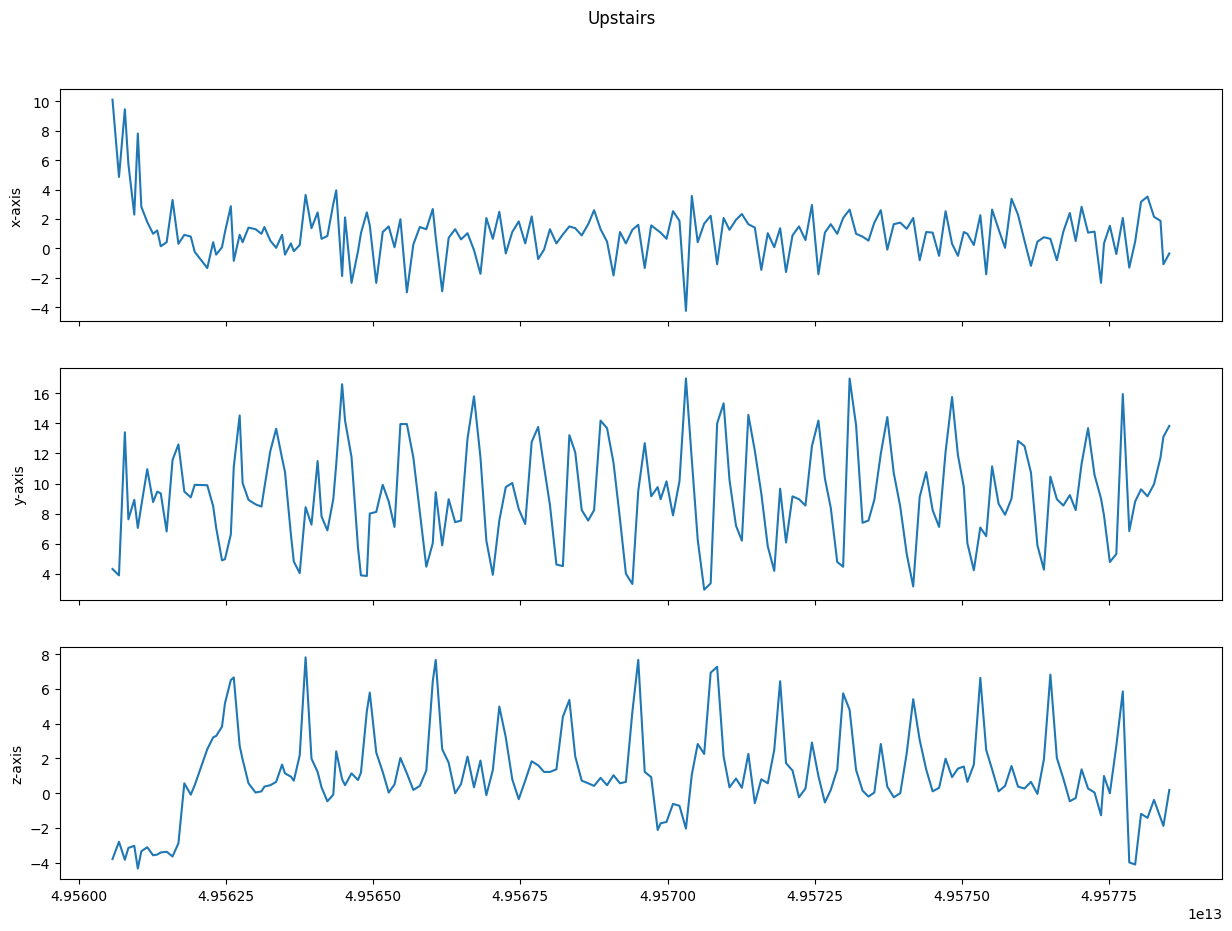

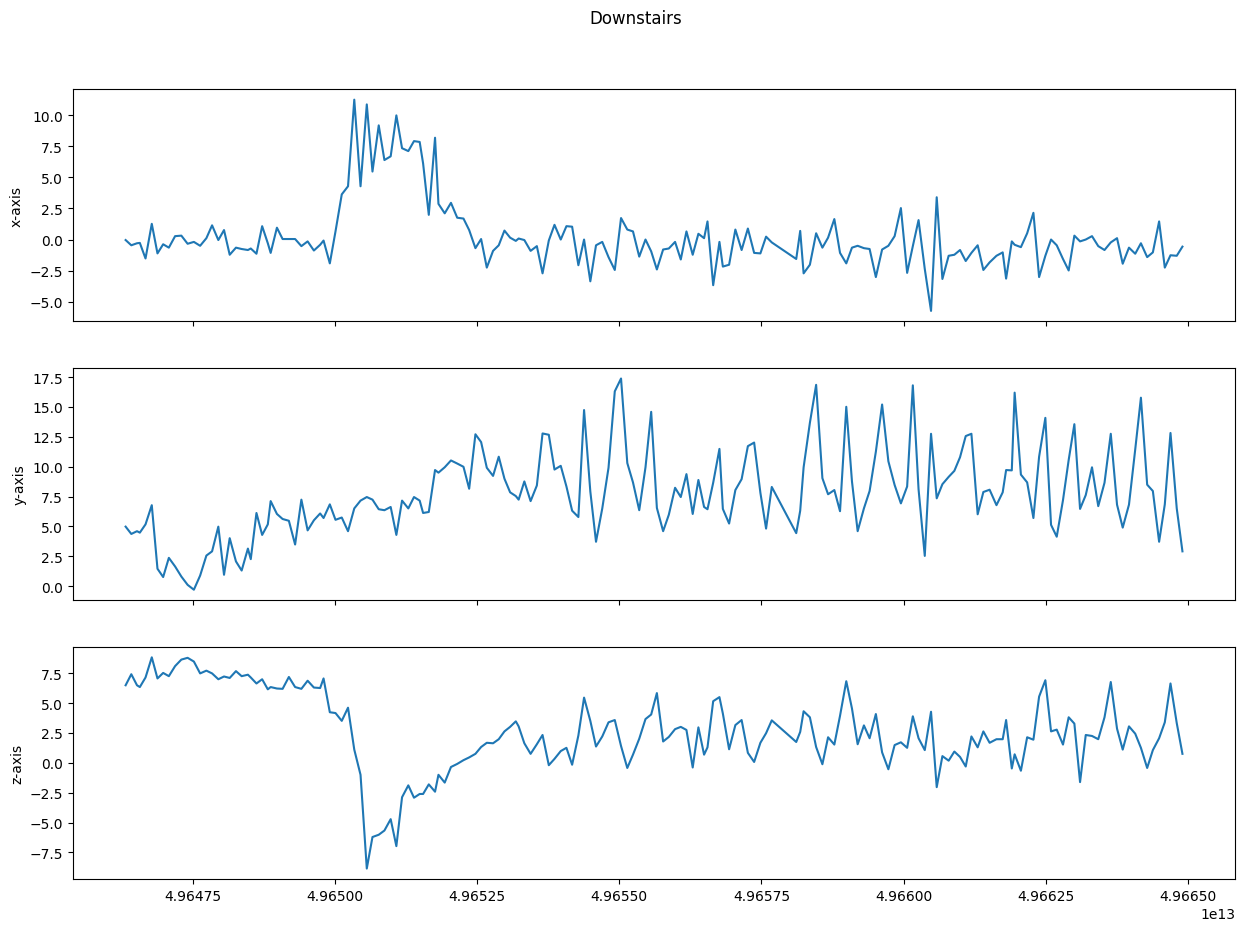

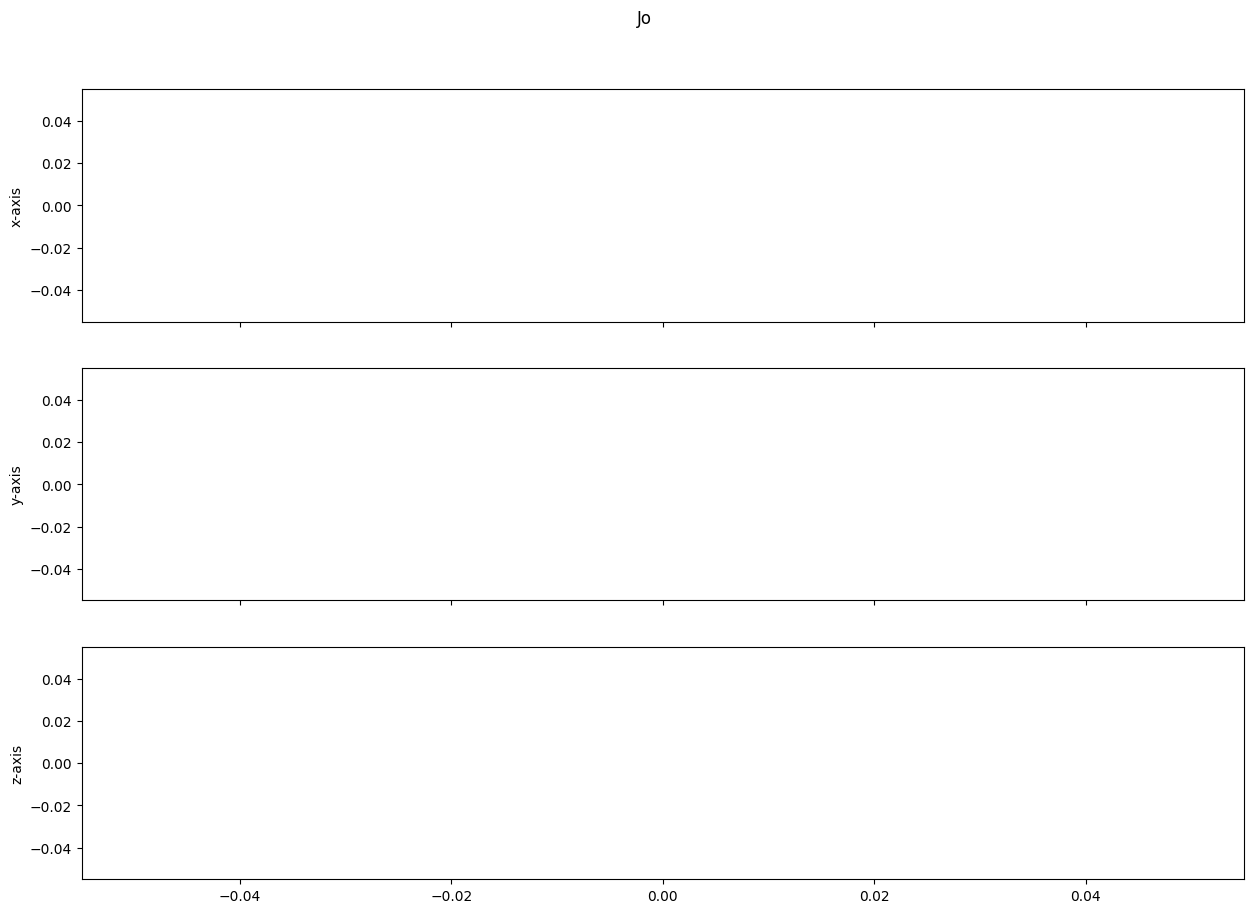

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def axis_plot(ax, x, y, label):
    ax.plot(x, y)
    ax.set_ylabel(label)

for activity in df['activity'].unique():
    limit = df[df['activity'] == activity][:180]

    # Remove rows with NaN or Inf values
    limit = limit[np.isfinite(limit['X']) & np.isfinite(limit['Y']) & np.isfinite(limit['Z'])]
    limit = limit.dropna(subset=['timestamp', 'X', 'Y', 'Z'])

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()


In [ ]:
label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
df

,user-id,activity,timestamp,X,Y,Z,activityEncode
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953,2
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424,2
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722,2
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717,2
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164,2
...,...,...,...,...,...,...,...
109061,13,Jogging,1.512342e+12,-2.830000,16.780000,3.677494,2
109062,13,Jogging,1.512393e+12,-8.160000,1.730000,-9.806650,2
109063,13,Jogging,1.512442e+12,-8.770000,19.110000,-6.129157,2
109064,13,Jogging,1.512493e+12,5.370000,19.380000,13.593107,2


In [ ]:
interpolation_fn = interp1d(df['activityEncode'] ,df['Z'], kind='linear')
null_list = df[df['Z'].isnull()].index.tolist()
for i in null_list:
    y = df['activityEncode'][i]
    value = interpolation_fn(y)
    df['Z']=df['Z'].fillna(value)
    print(value)

nan


In [ ]:
## train split users between 1 and 27, test split users between 28 and 33
df_test = df[df['user-id'] > 27]
df_train = df[df['user-id'] <= 27]

In [ ]:
df_train['X'] = (df_train['X']-df_train['X'].min())/(df_train['X'].max()-df_train['X'].min())
df_train['Y'] = (df_train['Y']-df_train['Y'].min())/(df_train['Y'].max()-df_train['Y'].min())
df_train['Z'] = (df_train['Z']-df_train['Z'].min())/(df_train['Z'].max()-df_train['Z'].min())
df_train

,user-id,activity,timestamp,X,Y,Z,activityEncode
8489,17,Walking,5.786990e+13,0.510362,0.712876,0.463763,4
8490,17,Walking,5.787001e+13,0.495619,0.724089,0.462636,4
8491,17,Walking,5.787012e+13,0.489651,0.714077,0.459256,4
8492,17,Walking,5.787022e+13,0.499480,0.720885,0.464514,4
8493,17,Walking,5.787033e+13,0.499480,0.722887,0.461510,4
...,...,...,...,...,...,...,...
109061,13,Jogging,1.512342e+12,0.422680,0.917899,0.579797,2
109062,13,Jogging,1.512393e+12,0.285309,0.475414,0.208036,2
109063,13,Jogging,1.512442e+12,0.269588,0.986404,0.309425,2
109064,13,Jogging,1.512493e+12,0.634021,0.994342,0.853173,2


In [ ]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]

        label = mode(df[label_name][i:i+time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [ ]:
!pip install scipy
from scipy.stats import mode
import numpy as np

def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]

        # Handle the case where mode returns a single value
        label_mode = mode(df[label_name][i:i+time_steps])
        label = label_mode.mode[0] if label_mode.count[0] > 0 else None

        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [ ]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['X'].values[i:i+time_steps]
        ys = df['Y'].values[i:i+time_steps]
        zs = df['Z'].values[i:i+time_steps]

        # Handle the case where mode returns a single value
        label = mode(df[label_name][i:i+time_steps])
        if isinstance(label, np.ndarray):  # Check if it's an array
            label = label[0][0]
        else:
            label = label  # Use the single value directly

        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [ ]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activityEncode'
x_train, y_train = segments(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [ ]:
print('x_train shape:', x_train.shape)
print('Training samples:', x_train.shape[0])
print('y_train shape:', y_train.shape)

x_train shape: (1252, 80, 3)
Training samples: 1252
y_train shape: (1252, 2)


In [ ]:
## Input and Output Dimensions
time_period, sensors = x_train.shape[1], x_train.shape[2]
num_classes = label_encode.classes_.size
print(list(label_encode.classes_))

['Downstairs', 'Jo', 'Jogging', 'Upstairs', 'Walking']


In [ ]:
## reshaping data
input_shape = time_period * sensors
x_train = x_train.reshape(x_train.shape[0], input_shape)
print("Input Shape: ", input_shape)
print("Input Data Shape: ", x_train.shape)

Input Shape:  240
Input Data Shape:  (1252, 240)


In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(input_shape,1), activation='relu'))
model.add(LSTM(32,return_sequences=True, activation='relu'))
model.add(Reshape((1, 240, 32)))
model.add(Conv1D(filters=64,kernel_size=2, activation='relu', strides=2))
model.add(Reshape((120, 64)))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(Reshape((29, 192)))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06))
model.add(Dense(6))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 240, 32)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 240, 32)           8320      
                                                                 
 reshape (Reshape)           (None, 1, 240, 32)        0         
                                                                 
 conv1d (Conv1D)             (None, 1, 120, 64)        4160      
                                                                 
 reshape_1 (Reshape)         (None, 120, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 30, 64)            0         
 D)                                                              
                                                        

In [ ]:
print(x_train.shape)
print(y_train_hot.shape)


(1252, 240)
(2504, 26)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Load data from CSV
data = pd.read_csv('WISDM_ar_v1.1_raw.txt')

# Assuming the last column is the target and the rest are features
x_data = data.iloc[:, :-1].values
y_data = data.iloc[:, -1].values

# --- BEGIN_SOLUTION
# Get unique labels from y_data
unique_labels = set(y_data)

# Create a label mapping for all unique labels
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Convert target values to integers
y_data = np.array([label_mapping[label] for label in y_data])
# --- END_SOLUTION

# Define the number of classes for one-hot encoding
num_classes = len(unique_labels) # Set to the number of unique labels

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train_hot = to_categorical(y_train, num_classes=num_classes)
y_val_hot = to_categorical(y_val, num_classes=num_classes)

# Verify the shapes of the training and validation data
print(x_train.shape)  # Should be (n_samples_train, n_features)
print(y_train_hot.shape)  # Should be (n_samples_train, num_classes)
print(x_val.shape)  # Should be (n_samples_val, n_features)
print(y_val_hot.shape)  # Should be (n_samples_val, num_classes)

(87252, 5)
(87252, 878)
(21813, 5)
(21813, 878)


In [ ]:
# Assuming the second column contains the string labels
labels = x_train[:, 1]
x_train_numeric = np.delete(x_train, 1, axis=1).astype('float32')  # Remove the second column and convert the rest

# ... rest of your code ...

# If you need to use the labels later, you can convert them to numerical values:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [ ]:
df_test['X'] = (df_test['X']-df_test['X'].min())/(df_test['X'].max()-df_test['X'].min())
df_test['Y'] = (df_test['Y']-df_test['Y'].min())/(df_test['Y'].max()-df_test['Y'].min())
df_test['Z'] = (df_test['Z']-df_test['Z'].min())/(df_test['Z'].max()-df_test['Z'].min())
x_test, y_test = segments(df_test,
                         TIME_PERIOD,
                         STEP_DISTANCE,
                         LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test = to_categorical(y_test, num_classes)

In [ ]:
predictions = model.predict(x_test)
y_test_pred = np.argmax(y_test, axis=1)  # Get binary representation of true labels
y_pred = np.argmax(predictions, axis=1)   # Get binary representation of predicted labels

plt.show()

46/46 [==============================] - 3s 67ms/step
